In [1]:
import requests
import pandas as pd
import certifi
import json
from urllib.request import urlopen
from datetime import datetime
import time
import pandas_ta as ta
import numpy as np


# data = dataframe in pandas format to calculate sma
# sma_value = is an array to calcuate the lenth of sma 
# variable = variable used to calculate sma, it can be a "Close", or "Adj Close" in string format
def sma(data,sma_value,variable):
     # auto assign a variable name based on length of sma 
    variable_name = 'SMA'+ str(sma_value)
    # calculate sma 
    data[variable_name] =ta.sma(data[variable], length=sma_value)
    # return sma variable calculated 
    return data[variable_name]


def get_jsonparsed_data(url):
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return pd.DataFrame(json.loads(data))


def highest_value(data, window):
    return data.rolling(window=window).max()
def lowest_value(data, window):
    return data.rolling(window=window).min()
def highest_bars(data, window):
    return data.rolling(window=window).apply(lambda x: x.argmax())
def lowest_bars(data, window):
    return data.rolling(window=window).apply(lambda x: x.argmin())
# Define the weight function
def weight(fng, dist):
    return fng + fng / dist

def Get_Signal(data):    
    #table start
    df_init =  data.copy()
    
    '''To make sure row arrange in an ascending order'''
    df_init.sort_values(by = 'date',inplace=True)
    
    #df_init.loc[df_init['SMA20']<df_init['SMA60'],'Signal']=-1
    #df_init.loc[df_init['bufferSMA20']<df_init['buffer5'],'Signal']=-1

    ''' move the signal of today to tmr, thus, we need to define a shift(1), as the signal buy is based on yesterday'''
    df_init['Signal'] = df_init['Signal'].shift(1)
    
    '''after we have a buy and sell signal, lets create a hold signal which is equal to 2 after a buy signal and
    a do nothing signal which is equal to 0 after a sell signal'''
    
    # In order to make a decision on a hold or do nothing signal based on yesterday signal we need to create a for loop 
    # a calendar date should be created to used for a a for loop 
    date_list = df_init.date.unique()
    
    # declare a first day, the first date is a null in signal as there is no yesterday data for first data
    first_date = date_list[0]
    
    # declare a previous day 
    prev = first_date 
    
    for i in date_list:
        if i == first_date:
            df_init.loc[df_init.date == i,'Signal'] = 0 
        else:
            
    
            #print(prev)
            # if you have a sell signal yesterday, you should have a do nothing signal today
            if (df_init.loc[(df_init.date == prev),'Signal'].values[0]==-1):
                df_init.loc[df_init.date == i,'Signal']=0 
            # if you have a buy signal yesterday, you should have a hold signal today
            elif (df_init.loc[(df_init.date == prev)  ,'Signal'].values[0]==1):
                df_init.loc[df_init.date == i,'Signal'] = 2

            # if you have a hold signal yesterday and you do not have a sell signal today, you should have a hold signal today
            elif ((df_init.loc[(df_init.date == prev) ,'Signal'].values[0]==2)&(df_init.loc[(df_init.date == i) ,'Signal'].values[0]!=-1) ):
                df_init.loc[df_init.date == i,'Signal'] = 2

            # if you have a do nothing signal yesterday and today is a sell signal, you should equal to have a do nothing signal
            elif ((df_init.loc[(df_init.date == prev) ,'Signal'].values[0]==0)&(df_init.loc[(df_init.date == i) ,'Signal'].values[0]==-1) ):
                df_init.loc[df_init.date == i,'Signal'] = 0
                
        # redeclare your previous date before to next day in for loop
        prev = i
    
    return df_init

In [2]:
import datetime
def backtest_strategy(data,capital):   
    
    #table start
    df_init =  data.copy()
    df_init.date =pd.to_datetime(df_init.date)
    df_init.set_index('date',inplace=True) 
    
    #assign dummy row - day before the trade
    start_date = pd.DataFrame(columns=data.columns,index=[df_init.index.min()- datetime.timedelta(days=1)])
    df_init = df_init.append(start_date)
    
    #initiat 2 variable: cash and units which represent each status of cash and units of apple holding for each day
    df_init = df_init.assign(cash=np.nan,units = 0)
    
    #assign capital for first dummy day assigned to be capital defined in function
    df_init.loc[pd.Series(df_init.index.min()), 'cash'] = capital
    df_init.Signal.fillna(0,inplace=True)
    # obtain list of calendar 
    calendar = pd.Series(df_init.index.sort_values().unique()).iloc[1:]
    
    
    ''' assign a variable which is trade, earn trade and lost trade to calculate total number of trade, total earn trade 
    and total lost trade'''
    trade = 0
    earn_trade = 0
    loss_trade = 0
    start_cap =0
    ''' create an array to keep all earn value and lost value for each trade'''
    earn_value =[]
    lost_value =[]

    for date in calendar:
        
        #get yesterday data
        prev_date = df_init.index[df_init.index<date].unique().sort_values()[-1]
        
        # calculate total stock value of yesterday 
        stock_holding = df_init.loc[(df_init.index==prev_date), 'units'].values[0]*df_init.loc[(df_init.index==date),'Price'].values[0]
        
        # total portfolio value by add cash and stock value of yesterday 
        port_value = stock_holding + df_init.loc[prev_date, 'cash'].sum()

        # if Signal is do nothing, mean our cash = portfolio value and units=0
        if df_init.loc[(df_init.index==date), 'Signal'].values[0] == 0:          
            df_init.loc[(df_init.index==date), 'units'] = 0
            df_init.loc[(df_init.index==date), 'cash'] =port_value        
        #if we have a buy Signal 
        #start to calculate the trade
        #we start to calculate start_cap which represent the starting capital for each trade
        #unit_buy is total unit buy based on port_value available
        elif df_init.loc[(df_init.index==date), 'Signal'].values[0] == 1:
            trade+=1
            start_cap = port_value 
            unit_buy = port_value/df_init.loc[(df_init.index==date), 'Price'].values[0]
            df_init.loc[(df_init.index==date), 'units'] = unit_buy
            df_init.loc[(df_init.index==date), 'cash'] = port_value - unit_buy*df_init.loc[(df_init.index==date), 'Price'].values[0]        
        
        #if we have a hold Signal or do nothing Signal,
        #mean today units hold and cash are same as yesterday units hold and yesterday cash
        elif ((df_init.loc[(df_init.index==date), 'Signal'].values[0] == 2) | (df_init.loc[(df_init.index==date), 'Signal'].values[0] == 0)): 
            df_init.loc[(df_init.index==date), 'units'] = df_init.loc[(df_init.index==prev_date), 'units'].values[0]
            df_init.loc[(df_init.index==date), 'cash'] =df_init.loc[(df_init.index==prev_date), 'cash'].values[0]
        
        #if we have a sell Signal,
        #1. we sell all the units at the today open price and thus units =0 and cash = port_value
        #2. we calculate the total earn/lost of this trade by using port_value - start cap of the trade and store as v variable
        #3. if v> 0, we store as earn_value array
        #4. if v<0, we store as lost trade
        elif (df_init.loc[(df_init.index==date), 'Signal'].values[0] == -1):
            df_init.loc[(df_init.index==date), 'units'] = 0
            df_init.loc[(df_init.index==date), 'cash'] =port_value 
            if (start_cap is None):
                0
            else:
                v = port_value  - start_cap 
                if v> 0: 
                    earn_value.append(v)
                    earn_trade +=1
                elif v<0: 
                    lost_value.append(v)
                    loss_trade+=1

    # calculate current value of the strategy, the formula = unit holding * Price + cash available
    df_init['Total_value_todate'] = df_init['units']*df_init['Price'] + df_init['cash'] 
    
    # append 0 to earn value array to prevent later calculation fail if there is no any earn trade
    earn_value.append(0)
    #remove dummy rows
    df_init.drop(df_init[df_init.index == df_init.index.min()].index,axis=0,inplace=True)
  
    # get summarize of total portfolio value, return by date, benchmark_index
    total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
    total_port_value['Return_without_trailing'] = total_port_value['Total_value_todate']/total_port_value['Total_value_todate'].iloc[0] *100
    total_port_value['Return_trailing_12m'] = total_port_value['Total_value_todate']/total_port_value['Total_value_todate'].shift(252)*100
    total_port_value['Return_without_trailingBuyAndHold'] = total_port_value['close']/total_port_value['close'].iloc[0] *100
    total_port_value['Return_trailing_12mBuyAndHold'] = total_port_value['close']/total_port_value['close'].shift(252)*100

    # to print out statistic to know how your strategy perform and the win change of this strategy
#     print('total_trade:',trade)
#     print('earn_trade:',earn_trade)
#     print('lost_trade:',loss_trade)
#     print('win_chance:',earn_trade/trade)
#     print('Max earning:',max(earn_value))
#     print('Max lost:',min(lost_value))
#     print('Average lost:',np.mean(lost_value))
#     print('Average Win:',np.mean(earn_value))
    return total_port_value, df_init

In [3]:

def get_weightbulbear(data,calc_period):


    data['SMA60'] = sma(data,60,'adjClose')
    data['SMA20'] = sma(data,20,'adjClose')
    data['close_highest'] = highest_value(data['adjClose'], window =calc_period)
    data['close_lowest'] = lowest_value(data['adjClose'], window =calc_period)
    data['close_highestBar'] = highest_bars(data['adjClose'], window =calc_period)
    data['close_highestBar']  =data['close_highestBar'] +1 -calc_period
    data['close_lowestBar'] = lowest_bars(data['adjClose'], window =calc_period)
    data['close_lowestBar'] = data['close_lowestBar'] +1 -calc_period
    # Calculate bear
    data['bear'] = -weight(data['close_highest'] -data['adjClose'],data['close_highestBar']  + 1)
    data['bull'] = +weight(data['adjClose'] - data['close_lowest'],data['close_lowestBar']   +1)
    data.loc[data['close_highestBar']  + 1==0 , 'bear'] = 0
    data.loc[data['close_lowestBar']  + 1==0 , 'bull'] = 0

    temp = data['bull']  * 2 + data['bear'] * 2
    data['buffer5'] = temp if temp is not None else np.nan
    data['bufferSMA20'] = sma(data,20,'buffer5')
    data['bufferSMA10'] = sma(data,10,'buffer5')
    #signal_condition
    #df_init['buffer5']<df_init['bufferSMA10']
    signal_condition = ((data['buffer5']>data['bufferSMA10']) & (data['adjClose']>data['SMA20']) )
    #signal_condition = (data['buffer5']>0 )
    data.loc[signal_condition ,'Signal']=1
    #Sellsignal_condition = (data['buffer5']<0 )
    Sellsignal_condition = (data['buffer5']<data['bufferSMA20'] )
    data.loc[Sellsignal_condition  ,'Signal']=-1
    data = Get_Signal(data)
    
    return data

In [4]:
# annualized return 
# df =data with return 
# variable = variable name of return
def annualized(df,variable):
    days_held =df.shape[0]
    Return = (df.iloc[-1][variable] - df.iloc[0][variable])/df.iloc[0][variable]
    ar = ((1+Return) ** (365/days_held))-1
    # get annualized in %
    return ar*100
# maximum drawdown 
# df =data with return 
# variable = variable name of return
def MDD(df,variable):
    window = 252
    Roll_Max = df[variable].rolling(window, min_periods=1).max()
    Drawdown = df[variable]/Roll_Max - 1.0
    mdd = Drawdown.min()
    # get drawdown in %
    return mdd*100

In [6]:
api =  'key in your API'

In [7]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
ticker_all = df['Symbol'].values
companyInfo = pd.DataFrame()
for temp_ticker in ticker_all:
    companyInfoAPI = 'https://financialmodelingprep.com/api/v3/profile/'+temp_ticker+'?apikey='+api
    temp_info = get_jsonparsed_data(companyInfoAPI)
    companyInfo = pd.concat([temp_info,companyInfo])

C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


In [8]:

from datetime import date
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
ticker_all = df['Symbol'].values

In [9]:
api =  'oX1sBTfvsAn0ALsUptoRGJCxFlY2iXCA'

backtest_resultOverall = pd.DataFrame()
port_valueOverall = pd.DataFrame()
compareAnnualizeOverall = pd.DataFrame()
# ticker_all = ['APA', 'BKR', 'CVX', 'COP', 'CTRA', 'DVN', 'FANG', 'EOG', 'EQT',
#        'XOM', 'HAL', 'HES', 'KMI', 'MRO', 'MPC', 'OXY', 'OKE', 'PSX',
#        'PXD', 'SLB', 'TRGP', 'VLO', 'WMB']
#ticker_all =compareAnnualizeOverall[compareAnnualizeOverall.sector=='Energy'].symbol.unique()
for temp_ticker in ticker_all:
    price_api = 'https://financialmodelingprep.com/api/v3/historical-price-full/'+temp_ticker+'?apikey='+api+'&from=2019-01-01&to=2023-12-27'
    price_temp = get_jsonparsed_data(price_api)
    price_temp = pd.json_normalize(price_temp['historical'])
    price_temp = price_temp.sort_values(by=['date'])
    price_temp['Symbol'] = temp_ticker
    period_tem = 50
    #for period_tem in period:
    print('calculate period:',period_tem)
    price_temp = get_weightbulbear(price_temp,period_tem)
    check = price_temp[price_temp['Signal']==-1] 
    print(temp_ticker)
    if check.shape[0]>1:
        price_temp['Price'] = price_temp['open']
        port_value, backtest_result = backtest_strategy(data = price_temp,capital =1000)

        backtest_resultOverall = pd.concat([backtest_resultOverall,backtest_result])
        port_value['Symbol'] = temp_ticker
        port_valueOverall = pd.concat([port_valueOverall,port_value])
        annualize_value = annualized (port_value,'Return_without_trailing')
        mdd_value = MDD(port_value,'Return_without_trailing')
        annualize_buyandhold = annualized (port_value,'Return_without_trailingBuyAndHold')
        mdd_buyandhold = MDD(port_value,'Return_without_trailingBuyAndHold')
        compareAnnualize = pd.DataFrame({'annualize_Strategy':[annualize_value],
                     'mdd_Strategy':[mdd_value],
                     'annualize_buyandhold': [annualize_buyandhold],
                     'mdd_buyandhold':[mdd_buyandhold],
                     'Symbol':[temp_ticker]})
        compareAnnualizeOverall = pd.concat([compareAnnualizeOverall,compareAnnualize])
    

C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MMM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AOS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ABT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ABBV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ACN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ADBE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AMD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AES


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AFL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
A


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
APD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ABNB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AKAM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ALB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ARE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ALGN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ALLE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LNT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ALL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GOOGL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GOOG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AMZN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AMCR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AEE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AAL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AEP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AXP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AIG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AMT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AWK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AMP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AME


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AMGN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
APH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ADI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ANSS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AON


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
APA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AAPL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AMAT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
APTV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ACGL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ADM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ANET


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AJG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AIZ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
T


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ATO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ADSK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ADP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AZO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AVB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AVY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AXON


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BKR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BALL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BAC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BBWI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BAX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BDX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BRK.B


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BBY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BIO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TECH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BIIB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BLK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BKNG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BWA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BXP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BSX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BMY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
AVGO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BRO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BF.B


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BLDR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CDNS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CZR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CPT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CPB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
COF


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CAH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
KMX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CCL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CARR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CTLT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CAT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CBOE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CBRE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CDW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
COR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CNC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CNP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CDAY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CF


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CHRW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CRL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SCHW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CHTR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CVX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CMG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CHD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CINF


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CTAS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CSCO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
C


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CFG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CLX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CME


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CMS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
KO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CTSH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CMCSA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CMA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CAG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
COP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ED


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
STZ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CEG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
COO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CPRT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GLW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CTVA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CSGP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
COST


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CTRA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CCI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CSX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CMI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CVS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DHR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DRI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DVA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DAL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
XRAY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DVN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DXCM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FANG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DLR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DFS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DLTR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
D


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DPZ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DOV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DOW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DHI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DTE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DUK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EMN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ETN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EBAY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ECL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EIX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ELV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LLY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EMR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ENPH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ETR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EOG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EPAM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EQT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EFX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EQIX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EQR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ESS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ETSY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EVRG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ES


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EXC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EXPE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EXPD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
EXR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
XOM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FFIV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FDS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FICO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FAST


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FRT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FDX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FIS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FITB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FSLR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FLT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FMC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
F


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FTNT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FTV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FOXA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FOX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
BEN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
FCX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GRMN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
IT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GEHC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GEN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GNRC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GIS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GPC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GILD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GPN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HAL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HIG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HAS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HCA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PEAK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HSIC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HSY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HES


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HPE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HLT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HOLX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HON


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HRL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HST


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HWM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HPQ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HUBB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HUM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HBAN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
HII


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
IBM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
IEX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
IDXX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ITW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ILMN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
INCY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
IR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PODD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
INTC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ICE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
IFF


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
IP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
IPG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
INTU


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ISRG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
IVZ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
INVH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
IQV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
IRM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
JBHT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
JBL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
JKHY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
J


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
JNJ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
JCI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
JPM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
JNPR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
K


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
KVUE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
KDP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
KEY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
KEYS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
KMB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
KIM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
KMI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
KLAC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
KHC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
KR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LHX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LRCX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LVS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LDOS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LEN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LIN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LYV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LKQ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LMT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
L


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LOW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LULU


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LYB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MTB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MRO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MPC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MKTX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MAR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MMC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MLM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MAS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MTCH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MKC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MCD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MCK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MDT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MRK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
META


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MET


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MTD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MGM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MCHP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MU


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MSFT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MAA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MRNA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MHK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MOH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TAP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MDLZ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MPWR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MNST


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MCO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MOS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MSI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
MSCI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NDAQ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NTAP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NFLX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NEM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NWSA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NWS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NEE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NKE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NDSN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NSC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NTRS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NOC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NCLH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NRG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NUE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NVDA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NVR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NXPI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ORLY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
OXY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ODFL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
OMC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ON


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
OKE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ORCL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
OTIS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PCAR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PKG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PANW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PARA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PAYX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PAYC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PYPL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PNR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PEP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PFE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PCG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PSX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PNW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PXD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PNC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
POOL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PPG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PPL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PFG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PGR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PLD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PRU


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PEG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PTC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PSA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PHM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
QRVO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
PWR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
QCOM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DGX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
RL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
RJF


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
RTX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
O


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
REG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
REGN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
RF


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
RSG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
RMD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
RVTY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
RHI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ROK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ROL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ROP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ROST


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
RCL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SPGI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
CRM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SBAC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SLB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
STX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SRE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
NOW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SHW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SPG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SWKS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SJM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SNA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
LUV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SWK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SBUX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
STT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
STLD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
STE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SYK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SYF


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SNPS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
SYY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TMUS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TROW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TTWO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TPR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TRGP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TGT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TEL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TDY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TFX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TER


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TSLA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TXN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TXT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TMO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TJX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TSCO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TDG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TRV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TRMB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TFC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TYL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
TSN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
USB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
UBER


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
UDR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ULTA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
UNP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
UAL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
UPS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
URI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
UNH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
UHS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
VLO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
VTR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
VLTO
calculate period: 50
VRSN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
VRSK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
VZ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
VRTX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
VFC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
VTRS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
VICI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
V


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
VMC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WRB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WAB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WBA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WMT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
DIS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WBD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WAT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WEC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WFC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WELL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WST


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WDC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WRK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WHR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WMB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WTW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
GWW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
WYNN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
XEL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
XYL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
YUM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ZBRA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ZBH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ZION


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())
C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/2026335479.py:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


calculate period: 50
ZTS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_416/1045654372.py:93: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate','close'].sum())


In [11]:
compareAnnualizeOverall['annualizeStrategyMinusBuyHold'] = compareAnnualizeOverall['annualize_Strategy'] - compareAnnualizeOverall['annualize_buyandhold']
compareAnnualizeOverall = pd.merge(compareAnnualizeOverall,companyInfo[['symbol', 'sector']], left_on = ['Symbol'], right_on = ['symbol'])
compareAnnualizeOverall['MDDStrategyMinusBuyHold'] = compareAnnualizeOverall['mdd_Strategy'] - compareAnnualizeOverall['mdd_buyandhold']


In [12]:
# Define the bins and labels for the categories
#bins = [-float('inf'), 0, 10, 30, 50, float('inf')]
#labels = ['< 0', '0-10', '10-30', '30-50', 'more than 50']
bins = [-float('inf'), 0,  float('inf')]
labels = ['< 0', '>0']
# Create a new column 'annualize_strategy_category' using pd.cut
compareAnnualizeOverall['annualizeStrategyMinusBuyHoldCategory'] = pd.cut(compareAnnualizeOverall['annualizeStrategyMinusBuyHold'], bins=bins, labels=labels, right=False)

# Define the bins and labels for the categories
bins = [-float('inf'), 0, 10, 30, 50, float('inf')]
labels = ['< 0', '0-10', '10-30', '30-50', 'more than 50']
#bins = [-float('inf'), 0,  float('inf')]
#labels = ['< 0', '>0']
# Create a new column 'annualize_strategy_category' using pd.cut
compareAnnualizeOverall['MDDStrategyMinusBuyHoldCategory'] = pd.cut(compareAnnualizeOverall['MDDStrategyMinusBuyHold'], bins=bins, labels=labels, right=False)

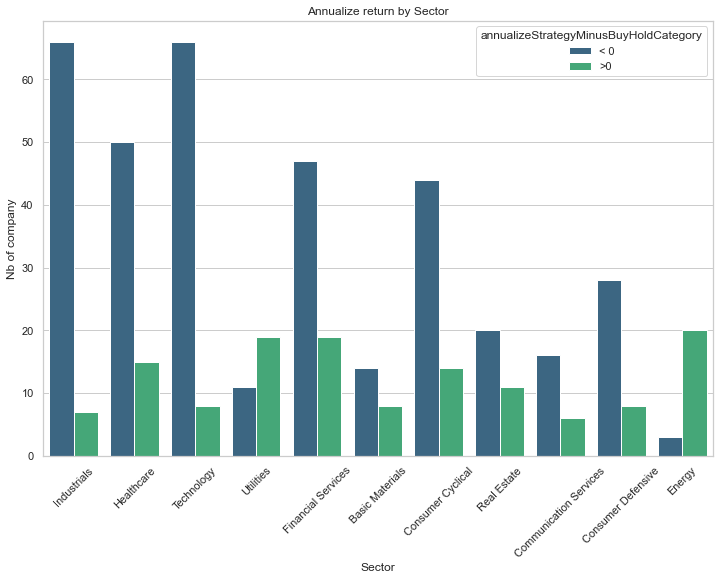

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# If it's not, replace df with the actual name of your DataFrame

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Define the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the area chart using seaborn
sns.countplot(data=compareAnnualizeOverall[compareAnnualizeOverall.sector!=''], x='sector', hue='annualizeStrategyMinusBuyHoldCategory', palette='viridis', ax=ax)

# Set plot labels and title
ax.set_xlabel('Sector')
ax.set_ylabel('Nb of company')
ax.set_title('Annualize return by Sector')

# Display the legend
#ax.legend(title='Category annualize return trade plan minus buy and hold', bbox_to_anchor=(1.05, 1))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()



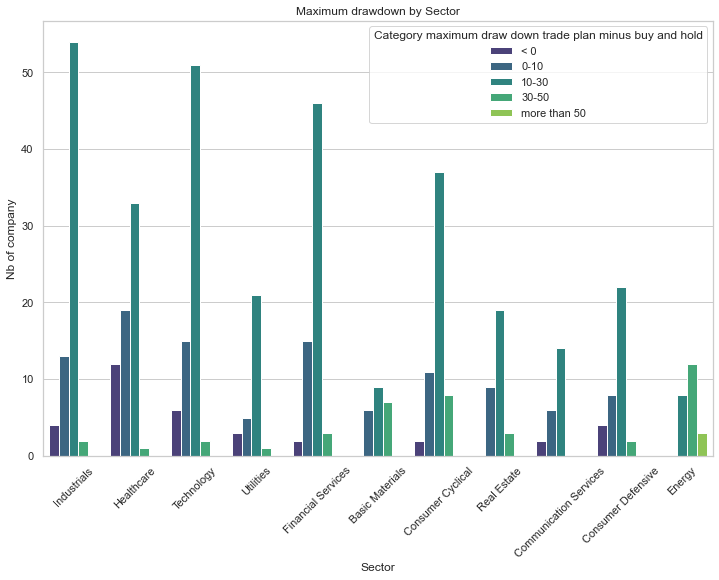

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# If it's not, replace df with the actual name of your DataFrame

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Define the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the area chart using seaborn
sns.countplot(data=compareAnnualizeOverall[compareAnnualizeOverall.sector!=''], x='sector', hue='MDDStrategyMinusBuyHoldCategory', palette='viridis', ax=ax)

# Set plot labels and title
ax.set_xlabel('Sector')
ax.set_ylabel('Nb of company')
ax.set_title('Maximum drawdown by Sector')

# Display the legend
ax.legend(title='Category maximum draw down trade plan minus buy and hold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [21]:
# Define the bins and labels for the categories
bins = [-float('inf'), 0, 10, 30, 50, float('inf')]
labels = ['<0', '0-10', '10-30', '30-50', 'more than 50']

# Create a new column 'annualize_strategy_category' using pd.cut
compareAnnualizeOverall['annualizeStrategyMinusBuyHoldCategory'] = pd.cut(compareAnnualizeOverall['annualizeStrategyMinusBuyHold'], bins=bins, labels=labels, right=False)

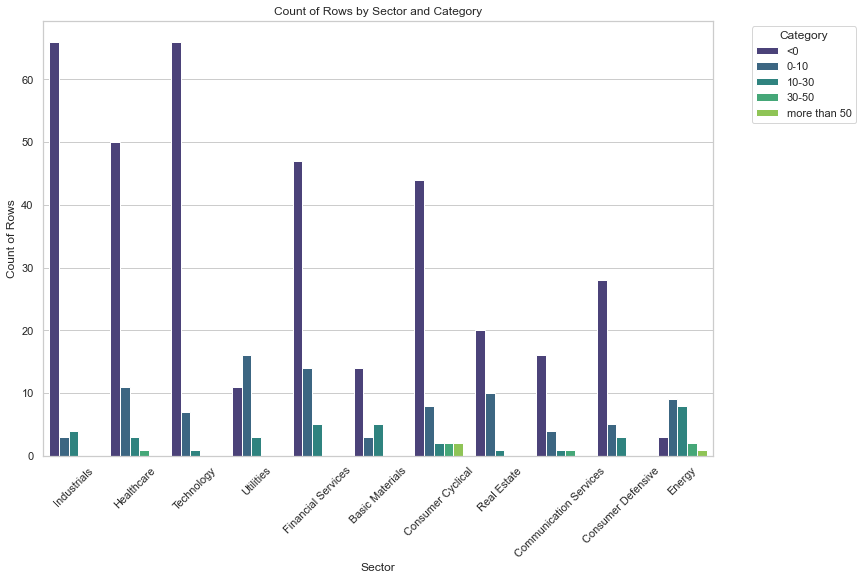

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# If it's not, replace df with the actual name of your DataFrame

# Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Define the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the area chart using seaborn
sns.countplot(data=compareAnnualizeOverall[compareAnnualizeOverall.sector!=''], x='sector', hue='annualizeStrategyMinusBuyHoldCategory', palette='viridis', ax=ax)

# Set plot labels and title
ax.set_xlabel('Sector')
ax.set_ylabel('Count of Rows')
ax.set_title('Count of Rows by Sector and Category')

# Display the legend
ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()